In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection

In [3]:
data = pd.read_csv('S&P_stock_data.csv')
test_data = pd.read_csv('test_data.csv')

In [4]:
data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


# Linear Regression

### This data might have some relationship with time
- x: time 
- y: open price

### Thus, we apply the data to linear regression model

In [5]:
reg = linear_model.LinearRegression(normalize= True)
y = data['Open Price']
x = np.arange(len(data))

x = np.expand_dims(x, 1)
x
reg.fit(x,y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

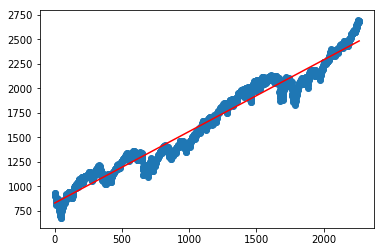

In [6]:
plt.scatter(x,y)
price = reg.coef_ * x + reg.intercept_

plt.plot(x, price, 'r')
plt.show()

In [7]:

x_test = np.arange(len(data), len(data)+len(test_data))
x_test = np.expand_dims(x_test, 1)

y_pred = reg.predict(x_test)
mse_train = metrics.mean_squared_error(test_data['Open Price'], y_pred)
mse_train

42379.067682961846

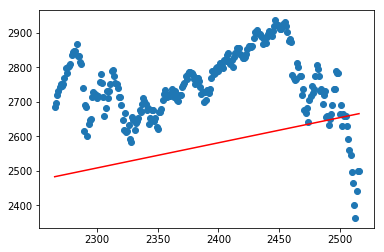

In [8]:
plt.scatter(x_test, test_data['Open Price'])
price = reg.coef_ * x_test + reg.intercept_

plt.plot(x_test, price, 'r')
plt.show()

### If we use this model there will be a massive error to the real issue.

# Logistic Regreesion

### We need to transform the orginal data because to apply logistic regression model, we have to label each data. In my way, I will lable the price that is higher than yesterday's price as one. On the other hand, the price lower than the price in yesterday as -1.

### Based on my suggestion, the price of the stock may somehow related to the 
### (Close Price - Open Price) and (High Price - Low Price)  yesterday, so we can use these two variables to predict the model tomorrow.

## Data Discription

- first variable : yesterday Close price - yesterday Open price
- second variable : yesterday High price - yesterday Low price
- prediction: whether the stock will grow tommorow

### I will not consider time because due to the above observation, the price will increase with time. If we consider time, the investors should invest in any time because  S&P will grow in most of the case.  Moreover, time is not a vital factor because every investor will only care about today whether the stock price will grow or not. If the investors want to predict future price, he should wait until the day because there is other variations during the period.

In [98]:
data = pd.read_csv('S&P_stock_data.csv')
test_data = pd.read_csv('test_data.csv')

In [99]:
def LogRegRule(inputdata):
    for index, row in inputdata.iterrows():
        if index !=0:
            if int(inputdata.loc[index - 1, 'Close Price']) > int(row['Close Price'])  :
                inputdata.loc[index, 'growth'] = -1
            else :
                inputdata.loc[index, 'growth'] = 1


            inputdata.loc[index, 'var1'] = (inputdata.loc[index - 1, 'Close Price']) - (inputdata.loc[index - 1, 'Open Price'])
            inputdata.loc[index, 'var2'] = (inputdata.loc[index - 1, 'High Price']- (inputdata.loc[index - 1, 'Low Price']))
    return inputdata

In [100]:
data_train_SVM = LogRegRule(data)
data_test_SVM = LogRegRule(test_data)
data_train_SVM = data_train_SVM.drop(0, axis=0)
data_test_SVM = data_test_SVM.drop(0, axis =0)


In [101]:
X_train = data_train_SVM[['var1', 'var2']]
y_train = data_train_SVM['growth']
X_test = data_test_SVM[['var1', 'var2']]
y_test = data_test_SVM['growth']

## Feature scaling

In [102]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 2.08951546,  1.85947401],
       [-0.17383835,  0.00992304],
       [ 0.21537251, -0.04370179],
       ...,
       [-0.00777505, -1.03930253],
       [ 0.06042952, -1.21737746],
       [-1.1983896 ,  0.15258534]])

## Fit the data into logistic regression model

In [103]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
accuracy = classifier.score(X_test,y_test)
print(accuracy)

0.5258964143426295


## Visualization

In [105]:
from matplotlib.colors import ListedColormap
def plotLogRegression(X, y):
    X_set, y_set = X, y
    X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                         np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
    plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
                 alpha = 0.75, cmap = ListedColormap(['lightblue', 'lightgreen']))
    plt.xlim(X1.min(), X1.max())
    plt.ylim(X2.min(), X2.max())
    for i, j in enumerate(np.unique(y_set)):
        plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                    c = ['red', 'blue', 'lightgreen'][i], label = j)
    plt.title('Logistic Regression (Training set)')
    plt.xlabel('close price - open price')
    plt.ylabel('high price - low price')
    plt.legend()
    plt.show()

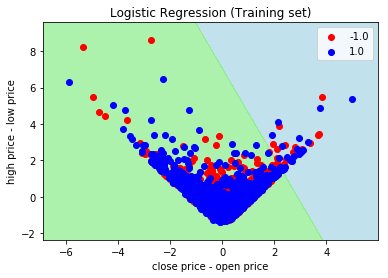

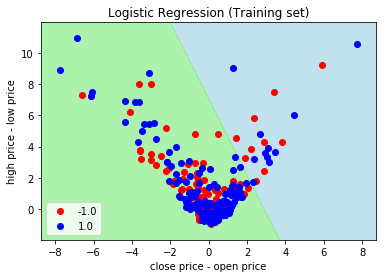

In [106]:
plotLogRegression(X_train, y_train)
plotLogRegression(X_test, y_test)

### 模型只有五成準確度，換句話說如果前一天漲幅很高，隔天就可能也會繼續漲

### Modification

### 必須漲超過一定幅度，才會算是有漲

In [205]:
data = pd.read_csv('S&P_stock_data.csv')
test_data = pd.read_csv('test_data.csv')

In [206]:
def LogRegRule_mod(inputdata):
    for index, row in inputdata.iterrows():
        if index !=0:
            if int(inputdata.loc[index - 1, 'Close Price']) > int(row['Close Price'] + 5)  :
                inputdata.loc[index, 'growth'] = -1
            else :
                inputdata.loc[index, 'growth'] = 1


            inputdata.loc[index, 'var1'] = (inputdata.loc[index - 1, 'Close Price']) - (inputdata.loc[index - 1, 'Open Price'])
            inputdata.loc[index, 'var2'] = (inputdata.loc[index - 1, 'High Price']- (inputdata.loc[index - 1, 'Low Price']))
    return inputdata

In [207]:
data_train_SVM = LogRegRule(data)
data_test_SVM = LogRegRule(test_data)
data_train_SVM = data_train_SVM.drop(0, axis=0)
data_test_SVM = data_test_SVM.drop(0, axis =0)


In [208]:
X_train = data_train_SVM[['var1', 'var2']]
y_train = data_train_SVM['growth']
X_test = data_test_SVM[['var1', 'var2']]
y_test = data_test_SVM['growth']

## Feature scaling

In [209]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[ 2.08951546,  1.85947401],
       [-0.17383835,  0.00992304],
       [ 0.21537251, -0.04370179],
       ...,
       [-0.00777505, -1.03930253],
       [ 0.06042952, -1.21737746],
       [-1.1983896 ,  0.15258534]])

## Fit the data into logistic regression model

In [210]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [211]:
y_pred = classifier.predict(X_test)
from sklearn.metrics import confusion_matrix
accuracy = classifier.score(X_test,y_test)
print(accuracy)

0.5258964143426295


### Visulization

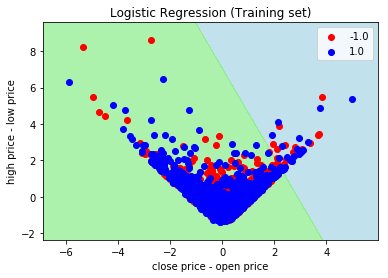

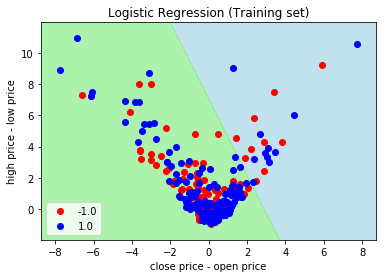

In [212]:
plotLogRegression(X_train, y_train)
plotLogRegression(X_test, y_test)

## Discussion 

### 正確率並沒有提升，可以由圖形發現此數據無法用線性方式分割，所以準確度很低，可知此種問題不適合用Logistic Regression來做。

# SVM

### We need to transform the orginal data because to apply logistic regression model, we have to label each data. In my way, I will lable the price that is higher than yesterday's price as one. On the other hand, the price lower than the price in yesterday as -1.

### Based on my suggestion, the price of the stock may somehow related to the 
### (Close Price - Open Price) and (High Price - Low Price)  yesterday, so we can use these two variables to predict the model tomorrow.

In [115]:
data = pd.read_csv('S&P_stock_data.csv')
test_data = pd.read_csv('test_data.csv')

### We use the same data preprcess method

In [116]:
data_train_SVM = LogRegRule(data)
data_test_SVM = LogRegRule(test_data)
data_train_SVM = data_train_SVM.drop(0, axis=0)
data_test_SVM = data_test_SVM.drop(0, axis =0)


### The first row may be wrong, so I discard it.

### Extract var1 and var2 as two variable that may influence stock price

In [117]:
X_train = data_train_SVM[['var1', 'var2']]
y_train = data_train_SVM['growth']
X_test = data_test_SVM[['var1', 'var2']]
y_test = data_test_SVM['growth']

## Standardization

In [118]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)

In [119]:
from sklearn.svm import SVC

In [120]:
from sklearn.metrics import accuracy_score

# Custom kernel function
def my_kernel(X, Y):
    return np.dot(X, Y.T)
  
penalty = 0.05

svm = SVC(C=penalty, kernel="linear", probability=True)
svm.fit(X_train_std, y_train.values)
  
acc_rate = accuracy_score(y_test.values, svm.predict(X_test_std)) * 100
print("Penalty = %.2f, Accuracy = %.2f %%" % (penalty, acc_rate))
 

Penalty = 0.05, Accuracy = 52.99 %


### Visualization

In [121]:
from matplotlib.colors import ListedColormap

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.6, 
                    c = ['red', 'blue', 'lightgreen'][idx],
                    edgecolor='black',
                    marker=markers[idx], 
                    label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        if not versiontuple(np.__version__) >= versiontuple('1.9.0'):
            X_test, y_test = X[list(test_idx), :], y[list(test_idx)]
            warnings.warn('Please update to NumPy 1.9.0 or newer')
        else:
            X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    edgecolor='black',
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')

In [122]:
def plot_train_test(location, x, y):
  
    plt.subplot(1,2,location)

    plot_decision_regions(x, y, classifier=svm)
    if location == 1:
      plt.title("Training")
    elif location == 2:
      plt.title("Testing")
    plt.xlabel('close price - open price')
    plt.ylabel('high price - low price')
    plt.legend(loc='upper left')
    plt.tight_layout()
    

In [123]:
penalty = 0.05

svm = SVC(C=penalty, kernel="linear")
svm.fit(X_train_std, y_train.values)

acc_train = accuracy_score(y_train.values, svm.predict(X_train_std)) * 100
acc_test = accuracy_score(y_test.values, svm.predict(X_test_std)) * 100
print("Penalty = %.2f, Train accuracy = %.2f %%, Test accuracy = %.2f %%" % (penalty, acc_train, acc_test))

Penalty = 0.05, Train accuracy = 56.89 %, Test accuracy = 52.99 %


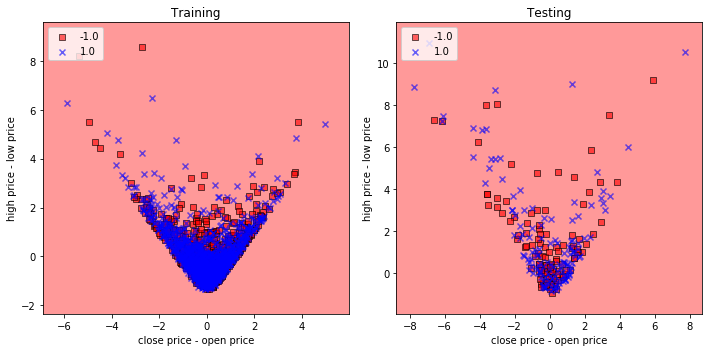

C: 0.05, Train Acc: 56.89 %, Test Acc: 52.99 %
Kernel function : linear


In [124]:
plt.figure(figsize=(10,5))

plot_train_test(1, X_train_std, y_train.values)
plot_train_test(2, X_test_std, y_test.values)

plt.show()

print("C: %.2f, Train Acc: %.2f %%, Test Acc: %.2f %%" % (penalty, acc_train, acc_test))
print("Kernel function : linear")

## Modification 

#### Apply data to the new rule

### Change the variable to only high price and open price

In [136]:
def newrule3(inputdata):
    for index, row in inputdata.iterrows():
        if index !=0:
            if int(inputdata.loc[index - 1, 'Open Price']) > int(row['Open Price'])  :
                inputdata.loc[index, 'growth'] = -1
            else :
                inputdata.loc[index, 'growth'] = 1


            inputdata.loc[index, 'var1'] = inputdata.loc[index - 1, 'Open Price']
            inputdata.loc[index, 'var2'] = inputdata.loc[index - 1, 'High Price']
    return inputdata

In [142]:
def trainWith(data, test_data, penalty = 0.05,  kernel="linear"):

    data_train_SVM = data.drop(0, axis=0)
    data_test_SVM = test_data.drop(0, axis =0)

    X_train = data_train_SVM[['var1', 'var2']]
    y_train = data_train_SVM['growth']
    X_test = data_test_SVM[['var1', 'var2']]
    y_test = data_test_SVM['growth']

    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_std = scaler.transform(X_train)
    X_test_std = scaler.transform(X_test)


    svm = SVC(C=penalty, kernel = kernel)
    svm.fit(X_train_std, y_train.values)

    acc_train = accuracy_score(y_train.values, svm.predict(X_train_std)) * 100
    acc_test = accuracy_score(y_test.values, svm.predict(X_test_std)) * 100
    print("Penalty = %.2f, Train accuracy = %.2f %%, Test accuracy = %.2f %%" % (penalty, acc_train, acc_test))

    plt.figure(figsize=(10,5))

    plot_train_test(1, X_train_std, y_train.values)
    plot_train_test(2, X_test_std, y_test.values)

    plt.show()

    print("C: %.2f, Train Acc: %.2f %%, Test Acc: %.2f %%" % (penalty, acc_train, acc_test))
    print("Kernel function : " + kernel)

### Now, let's try with rule3

Penalty = 0.05, Train accuracy = 58.08 %, Test accuracy = 53.39 %


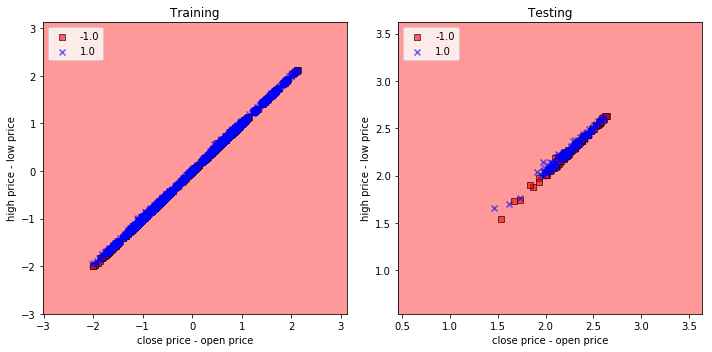

C: 0.05, Train Acc: 58.08 %, Test Acc: 53.39 %
Kernel function : linear


In [148]:
mod3_data = newrule3(data)
mod3_test_data = newrule3(test_data)
trainWith(mod3_data, mod3_test_data)

### Or, we could try another function, such as 'poly', or 'sigmoid', but the accuracy will become lower.

Penalty = 0.01, Train accuracy = 58.08 %, Test accuracy = 53.39 %


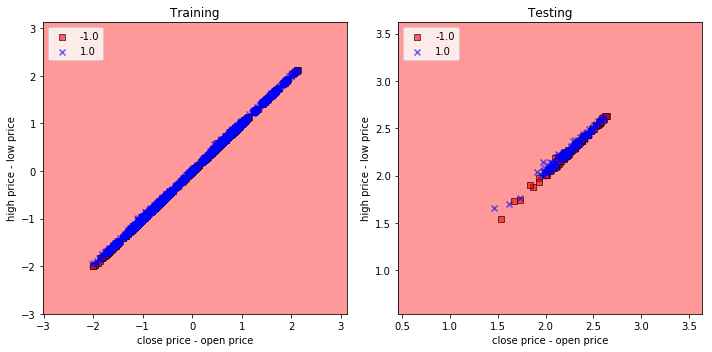

C: 0.01, Train Acc: 58.08 %, Test Acc: 53.39 %
Kernel function : poly


In [149]:
trainWith(mod2_data, mod2_test_data,penalty= 0.01, kernel= 'poly')

Penalty = 0.01, Train accuracy = 58.08 %, Test accuracy = 53.39 %


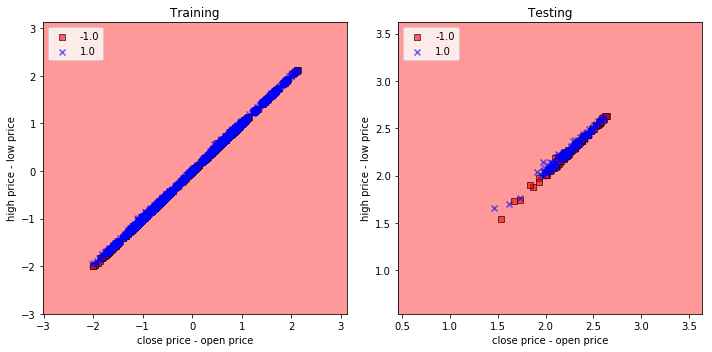

C: 0.01, Train Acc: 58.08 %, Test Acc: 53.39 %
Kernel function : sigmoid


In [150]:
trainWith(mod2_data, mod2_test_data,penalty= 0.01, kernel= 'sigmoid')

### Why the accuracy is so low???
### Because this data is much more difficult to analyze than other data. It is obvious that stock market price will not fluctuate just because of the stock price of yesterday. There are other factors that may influence the stock price. For example, the news of the stock, and the comprehensively market environment will change the result significantly. It is smart to avoid the data in 2008 when the depression was happened, but some other events like the recession in Europe around 2012 may influence the results. Hence, it is fair to say that using classification model to predict stock market is not quite a good idea. 

## Discussion

### Although the accuracy will improve after we apply the modified rule, the problem is the model predict stock price tomorrow will drop every day. Hence, the value of the model will vanished because investors cannot buy the stock based on the model.

### When we change the funtion, the accuracy will not imrpove because the model consider that the price will fall in any case. No matter which function we choose, the accuracy will not imrpove. In this case, SVM is not suitable for this question. On the other hand, we should choose Logistic Regression because at least, it can predict whether the price will fall or grow. 

## The best way to analyze unreasonable data is NN.

# NN

In [186]:
import tensorflow as tf #use Tensorflow 2.0

### Prepare the data

### Data discription:
- variable: I use every column except time.
- The model will predict whether the price tommorrow will grow tommorrow.

In [156]:
data = pd.read_csv('S&P_stock_data.csv')
test_data = pd.read_csv('test_data.csv')

In [157]:
def NNRule(inputdata):
    for index, row in inputdata.iterrows():
        if index !=0 and index != 1:
            if int(inputdata.loc[index - 2, 'Open Price']) > int(inputdata.loc[index - 1, 'Open Price'])  :
                inputdata.loc[index, 'growth'] = 0
            else :
                inputdata.loc[index, 'growth'] = 1
    return inputdata

In [158]:
data = NNRule(data)
test_data = NNRule(test_data)
data.drop([0,1], axis= 0 , inplace= True)
test_data.drop([0,1], axis= 0 , inplace= True)
data.drop(labels='Date', axis=1, inplace = True)
test_data.drop(labels='Date', axis=1, inplace = True)

X_train = data.loc[:, data.columns != 'growth']
y_train = data['growth']
X_test = test_data.loc[:, data.columns != 'growth']
y_test = test_data['growth']

data.head()

,Open Price,Close Price,High Price,Low Price,Volume,growth
2,931.17,934.70,943.85,927.28,5392620032,1.0
3,927.45,906.65,927.45,902.37,4704940032,1.0
4,905.73,909.73,910.00,896.81,4991549952,0.0
5,909.91,890.35,911.93,888.31,4716499968,0.0
6,890.40,870.26,890.40,864.32,4725049856,1.0


## Feature Scaling

In [161]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
X_train

array([[-1.49623224, -1.49034885, -1.48858209, -1.48538806,  1.81088461],
       [-1.50389803, -1.5481559 , -1.5224099 , -1.53668897,  1.30174877],
       [-1.54865636, -1.54180846, -1.55840351, -1.54813951,  1.51394541],
       ...,
       [ 2.12014594,  2.12200434,  2.10832441,  2.12979136, -1.34791513],
       [ 2.12643106,  2.0932966 ,  2.11752392,  2.11109155, -1.19518907],
       [ 2.11526209,  2.13904763,  2.12530019,  2.12911174, -0.81457419]])

### Import Keras

In [162]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Initialising the ANN

In [163]:
classifier = Sequential()

### Adding the input layer and the first hidden layer

In [164]:
hidden_units = 10    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 100         # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

In [165]:
classifier.add(Dense(activation = activation, input_dim =5, units = hidden_units ))

classifier.add(Dense(input_dim = hidden_units, units =1, activation = 'sigmoid'))

classifier.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer= 'adam',
              metrics=['accuracy'])

In [166]:
history = classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

# evaluate accuracy
train_acc = classifier.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = classifier.evaluate(X_test, y_test, batch_size=32)[1]
print('classifier accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)



Epoch 1/100
2263/2263 [==============================] - 0s 87us/sample - loss: 0.7550 - accuracy: 0.4335
Epoch 2/100
2263/2263 [==============================] - 0s 33us/sample - loss: 0.6950 - accuracy: 0.5241
Epoch 3/100
2263/2263 [==============================] - 0s 34us/sample - loss: 0.6895 - accuracy: 0.5471
Epoch 4/100
2263/2263 [==============================] - 0s 31us/sample - loss: 0.6869 - accuracy: 0.5678
Epoch 5/100
2263/2263 [==============================] - 0s 32us/sample - loss: 0.6849 - accuracy: 0.5705
Epoch 6/100
2263/2263 [==============================] - 0s 31us/sample - loss: 0.6829 - accuracy: 0.5762
Epoch 7/100
2263/2263 [==============================] - 0s 31us/sample - loss: 0.6820 - accuracy: 0.5802
Epoch 8/100
2263/2263 [==============================] - 0s 31us/sample - loss: 0.6810 - accuracy: 0.5793
Epoch 9/100
2263/2263 [==============================] - 0s 31us/sample - loss: 0.6807 - accuracy: 0.5802
Epoch 10/100
2263/2263 [======================

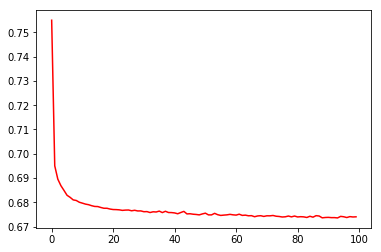

In [167]:
losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [168]:
test_acc = classifier.evaluate(X_test, y_test, batch_size=32)[1]
train_acc = classifier.evaluate(X_train, y_train, batch_size=32)[1]
print("test accuracy: " + str(test_acc))
print("training data accuracy"+str(train_acc))

2263/2263 [==============================] - 0s 17us/sample - loss: 0.6732 - accuracy: 0.5873
test accuracy: 0.532
training data accuracy0.58727354


### The accuracy of the NN is close to the result of Logistic Regression. 

### Now we try to alter the cooefficient. Increase epoch, and hiden layer.

In [169]:
hidden_units = 20
epochs= 400
classifier = Sequential()

classifier.add(Dense(activation = activation, input_dim =5, units = hidden_units ))

classifier.add(Dense(input_dim = hidden_units, units =hidden_units, activation = 'relu'))

classifier.add(Dense(input_dim = hidden_units, units =hidden_units, activation = 'relu'))

classifier.add(Dense(input_dim = hidden_units, units =hidden_units, activation = 'relu'))

classifier.add(Dense(input_dim = hidden_units, units =1, activation = 'sigmoid'))

classifier.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer= 'adam',
              metrics=['accuracy'])


Epoch 1/400
2263/2263 [==============================] - 0s 117us/sample - loss: 0.6823 - accuracy: 0.5811
Epoch 2/400
2263/2263 [==============================] - 0s 42us/sample - loss: 0.6791 - accuracy: 0.5811
Epoch 3/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6780 - accuracy: 0.5811
Epoch 4/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6775 - accuracy: 0.5824
Epoch 5/400
2263/2263 [==============================] - 0s 38us/sample - loss: 0.6772 - accuracy: 0.5811
Epoch 6/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6762 - accuracy: 0.5802
Epoch 7/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6763 - accuracy: 0.5815
Epoch 8/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6770 - accuracy: 0.5815
Epoch 9/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6761 - accuracy: 0.5815
Epoch 10/400
2263/2263 [=====================

2263/2263 [==============================] - 0s 36us/sample - loss: 0.6626 - accuracy: 0.5966
Epoch 153/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6629 - accuracy: 0.5961
Epoch 154/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6616 - accuracy: 0.6001
Epoch 155/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6627 - accuracy: 0.6001
Epoch 156/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6621 - accuracy: 0.5952
Epoch 157/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6620 - accuracy: 0.5966
Epoch 158/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6611 - accuracy: 0.5948
Epoch 159/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6620 - accuracy: 0.6001
Epoch 160/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6611 - accuracy: 0.5970
Epoch 161/400
2263/2263 [=================

Epoch 228/400
2263/2263 [==============================] - 0s 38us/sample - loss: 0.6548 - accuracy: 0.6094
Epoch 229/400
2263/2263 [==============================] - 0s 35us/sample - loss: 0.6561 - accuracy: 0.6067
Epoch 230/400
2263/2263 [==============================] - 0s 38us/sample - loss: 0.6565 - accuracy: 0.6094
Epoch 231/400
2263/2263 [==============================] - 0s 35us/sample - loss: 0.6564 - accuracy: 0.6120
Epoch 232/400
2263/2263 [==============================] - 0s 38us/sample - loss: 0.6557 - accuracy: 0.6120
Epoch 233/400
2263/2263 [==============================] - 0s 38us/sample - loss: 0.6563 - accuracy: 0.6116
Epoch 234/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6560 - accuracy: 0.6072
Epoch 235/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6548 - accuracy: 0.6103
Epoch 236/400
2263/2263 [==============================] - 0s 36us/sample - loss: 0.6558 - accuracy: 0.6098
Epoch 237/400
2263/2263 [===

Epoch 379/400
2263/2263 [==============================] - 0s 39us/sample - loss: 0.6492 - accuracy: 0.6160
Epoch 380/400
2263/2263 [==============================] - 0s 43us/sample - loss: 0.6461 - accuracy: 0.6195
Epoch 381/400
2263/2263 [==============================] - 0s 42us/sample - loss: 0.6471 - accuracy: 0.6186
Epoch 382/400
2263/2263 [==============================] - 0s 45us/sample - loss: 0.6463 - accuracy: 0.6156
Epoch 383/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6468 - accuracy: 0.6217
Epoch 384/400
2263/2263 [==============================] - 0s 39us/sample - loss: 0.6468 - accuracy: 0.6103
Epoch 385/400
2263/2263 [==============================] - 0s 37us/sample - loss: 0.6469 - accuracy: 0.6226
Epoch 386/400
2263/2263 [==============================] - 0s 53us/sample - loss: 0.6456 - accuracy: 0.6204
Epoch 387/400
2263/2263 [==============================] - 0s 53us/sample - loss: 0.6460 - accuracy: 0.6200
Epoch 388/400
2263/2263 [===

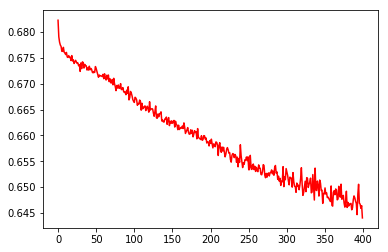

In [170]:
history = classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

# evaluate accuracy
train_acc = classifier.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = classifier.evaluate(X_test, y_test, batch_size=32)[1]
print('classifier accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

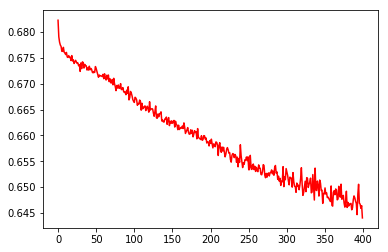

In [171]:
losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [172]:
test_acc = classifier.evaluate(X_test, y_test, batch_size=32)[1]
train_acc = classifier.evaluate(X_train, y_train, batch_size=32)[1]
print("test accuracy: " + str(test_acc))
print("training data accuracy"+str(train_acc))

2263/2263 [==============================] - 0s 21us/sample - loss: 0.6449 - accuracy: 0.6147
test accuracy: 0.552
training data accuracy0.6146708


## Modification <-- Amazing

## Analysis: Since stock market is a sequential result, if we put the previous days' data into the traing data, we may get a more accurate prediction. To varify it, the following will realize this idea.

### Now, we change the input data to improve the accuracy.

In [189]:
data = pd.read_csv('S&P_stock_data.csv')
test_data = pd.read_csv('test_data.csv')
data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952


In [190]:
def NNRule(inputdata):
    for index, row in inputdata.iterrows():
        if index !=0 and index !=1 and index !=2:
            if int(inputdata.loc[index - 1, 'Close Price']) > int(inputdata.loc[index - 1, 'Open Price'])  :
                inputdata.loc[index, 'growth'] = 1
            else :
                inputdata.loc[index, 'growth'] = 0
            inputdata.loc[index, 'yesterday_Open Price']= inputdata.loc[index-1, 'Open Price']
            inputdata.loc[index, 'yesterday_Cloe Price']= inputdata.loc[index-1, 'Close Price']
            inputdata.loc[index, 'yesterday_High Price']= inputdata.loc[index-1, 'High Price']
            inputdata.loc[index, 'yesterday_Low Price']= inputdata.loc[index-1, 'Low Price']
            inputdata.loc[index, 'yesterday_Volume Price']= inputdata.loc[index-1, 'Volume']
            
            inputdata.loc[index, 'yes_yes_Open Price']= inputdata.loc[index-2, 'Open Price']
            inputdata.loc[index, 'yes_yes_Cloe Price']= inputdata.loc[index-2, 'Close Price']
            inputdata.loc[index, 'yes_yes_High Price']= inputdata.loc[index-2, 'High Price']
            inputdata.loc[index, 'yes_yes_Low Price']= inputdata.loc[index-2, 'Low Price']
            inputdata.loc[index, 'yes_yes_Volume Price']= inputdata.loc[index-2, 'Volume']
    return inputdata

In [191]:
data = NNRule(data)
test_data = NNRule(test_data)

X_train = data.loc[:, data.columns != 'growth']
y_train = data['growth']
X_test = test_data.loc[:, data.columns != 'growth']
y_test = test_data['growth']
data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,growth,yesterday_Open Price,yesterday_Cloe Price,yesterday_High Price,yesterday_Low Price,yesterday_Volume Price,yes_yes_Open Price,yes_yes_Cloe Price,yes_yes_High Price,yes_yes_Low Price,yes_yes_Volume Price
0,02-Jan-2009,902.99,931.80,934.73,899.35,4048270080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,05-Jan-2009,929.17,927.45,936.63,919.53,5413910016,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,06-Jan-2009,931.17,934.70,943.85,927.28,5392620032,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,07-Jan-2009,927.45,906.65,927.45,902.37,4704940032,1.0,931.17,934.70,943.85,927.28,5.392620e+09,929.17,927.45,936.63,919.53,5.413910e+09
4,08-Jan-2009,905.73,909.73,910.00,896.81,4991549952,0.0,927.45,906.65,927.45,902.37,4.704940e+09,931.17,934.70,943.85,927.28,5.392620e+09


### Drop the rows that are incomplete

In [196]:
X_train.drop([0,1,2], axis= 0 , inplace= True)
X_test.drop([0,1,2], axis= 0 , inplace= True)
X_train.drop(labels='Date', axis=1, inplace = True)
X_test.drop(labels='Date', axis=1, inplace = True)
y_train.drop([0,1,2], axis= 0 , inplace= True)
y_test.drop([0,1,2], axis= 0 , inplace= True)

/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [197]:
X_test.head()

,Open Price,Close Price,High Price,Low Price,Volume,yesterday_Open Price,yesterday_Cloe Price,yesterday_High Price,yesterday_Low Price,yesterday_Volume Price,yes_yes_Open Price,yes_yes_Cloe Price,yes_yes_High Price,yes_yes_Low Price,yes_yes_Volume Price
3,2731.33,2743.15,2743.45,2727.92,1918869120,2719.31,2723.99,2729.29,2719.07,2.100768e+09,2697.85,2713.06,2714.37,2697.77,2.090595e+09
4,2742.67,2747.71,2748.51,2737.60,1894823936,2731.33,2743.15,2743.45,2727.92,1.918869e+09,2719.31,2723.99,2729.29,2719.07,2.100768e+09
5,2751.15,2751.29,2759.14,2747.86,1957263872,2742.67,2747.71,2748.51,2737.60,1.894824e+09,2731.33,2743.15,2743.45,2727.92,1.918869e+09
6,2745.55,2748.23,2750.80,2736.06,2048867328,2751.15,2751.29,2759.14,2747.86,1.957264e+09,2742.67,2747.71,2748.51,2737.60,1.894824e+09
7,2752.97,2767.56,2767.56,2752.78,1978592384,2745.55,2748.23,2750.80,2736.06,2.048867e+09,2751.15,2751.29,2759.14,2747.86,1.957264e+09


## Feature Scaling

In [198]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """


### Import Keras

In [199]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

### Initialising the ANN

In [200]:
classifier = Sequential()

### Adding the input layer and the first hidden layer

In [201]:
hidden_units = 20    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 400          # how many epochs to train for
batch_size = 32      # how many samples to use for each gradient descent update

In [202]:
classifier.add(Dense(activation = activation, input_dim =15, units = hidden_units ))

classifier.add(Dense(input_dim = hidden_units, units = hidden_units, activation = activation))

classifier.add(Dense(input_dim = hidden_units, units = hidden_units, activation = activation))

classifier.add(Dense(input_dim = hidden_units, units =1, activation = 'sigmoid'))

classifier.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer= 'adam',
              metrics=['accuracy'])

Epoch 1/400
2262/2262 [==============================] - 0s 108us/sample - loss: 0.6957 - accuracy: 0.5137
Epoch 2/400
2262/2262 [==============================] - 0s 40us/sample - loss: 0.6896 - accuracy: 0.5402
Epoch 3/400
2262/2262 [==============================] - 0s 37us/sample - loss: 0.6878 - accuracy: 0.5464
Epoch 4/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.6868 - accuracy: 0.5623
Epoch 5/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.6835 - accuracy: 0.5685
Epoch 6/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.6821 - accuracy: 0.5685
Epoch 7/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.6790 - accuracy: 0.5752
Epoch 8/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.6768 - accuracy: 0.5906
Epoch 9/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.6760 - accuracy: 0.5849
Epoch 10/400
2262/2262 [=====================

2262/2262 [==============================] - 0s 35us/sample - loss: 0.2737 - accuracy: 0.8758
Epoch 154/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.2587 - accuracy: 0.8890
Epoch 155/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.2794 - accuracy: 0.8753
Epoch 156/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.2717 - accuracy: 0.8691
Epoch 157/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.2539 - accuracy: 0.8868
Epoch 158/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.2543 - accuracy: 0.8811
Epoch 159/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.2631 - accuracy: 0.8806
Epoch 160/400
2262/2262 [==============================] - 0s 37us/sample - loss: 0.2662 - accuracy: 0.8771
Epoch 161/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.2645 - accuracy: 0.8789
Epoch 162/400
2262/2262 [=================

Epoch 229/400
2262/2262 [==============================] - 0s 38us/sample - loss: 0.2353 - accuracy: 0.8904
Epoch 230/400
2262/2262 [==============================] - 0s 39us/sample - loss: 0.2116 - accuracy: 0.9098
Epoch 231/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.2217 - accuracy: 0.8974
Epoch 232/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.2397 - accuracy: 0.8882
Epoch 233/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.2166 - accuracy: 0.9019
Epoch 234/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.2330 - accuracy: 0.8930
Epoch 235/400
2262/2262 [==============================] - 0s 34us/sample - loss: 0.2302 - accuracy: 0.8992
Epoch 236/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.2119 - accuracy: 0.9032
Epoch 237/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.2244 - accuracy: 0.8957
Epoch 238/400
2262/2262 [===

Epoch 380/400
2262/2262 [==============================] - 0s 37us/sample - loss: 0.1811 - accuracy: 0.9134
Epoch 381/400
2262/2262 [==============================] - 0s 37us/sample - loss: 0.1683 - accuracy: 0.9240
Epoch 382/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.2137 - accuracy: 0.9072
Epoch 383/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.2183 - accuracy: 0.8996
Epoch 384/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.2281 - accuracy: 0.8873
Epoch 385/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.1716 - accuracy: 0.9231
Epoch 386/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.1707 - accuracy: 0.9209
Epoch 387/400
2262/2262 [==============================] - 0s 36us/sample - loss: 0.1899 - accuracy: 0.9151
Epoch 388/400
2262/2262 [==============================] - 0s 35us/sample - loss: 0.1839 - accuracy: 0.9191
Epoch 389/400
2262/2262 [===

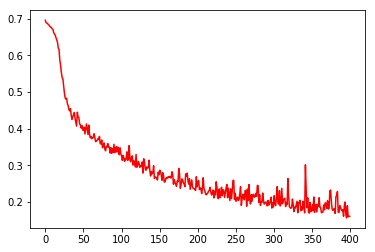

In [203]:
history = classifier.fit(X_train, y_train, batch_size=batch_size, epochs=epochs)

# evaluate accuracy
train_acc = classifier.evaluate(X_train, y_train, batch_size=32)[1]
test_acc = classifier.evaluate(X_test, y_test, batch_size=32)[1]
print('classifier accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')


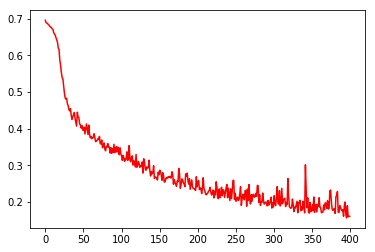

In [204]:
losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [185]:
test_acc = classifier.evaluate(X_test, y_test, batch_size=32)[1]
train_acc = classifier.evaluate(X_train, y_train, batch_size=32)[1]
print("test accuracy: " + str(test_acc))
print("training data accuracy"+str(train_acc))

2262/2262 [==============================] - 0s 19us/sample - loss: 0.1245 - accuracy: 0.9523
test accuracy: 0.8875502
training data accuracy0.95225465


## Ecitingly, the accuracy improved significantly!! 

## Discussion

### 1.本次作業採用的preprocess方式是影響結果很重要的因素，我的想法是股票的漲跌可能和前日的漲幅有關，即也許幅度越大漲越多，但是可以想見結果會很不準確，因為沒有任何理論基礎，和理性的推斷。但是最後一個NN的preprocess, 我認為是最佳的，因為根據股票的性質，採取更多天作為參考，可以大幅增加準確度。之所以把數據預測結果簡化成漲跌是因為可以簡化模型，增加準確度，因為如果預測股票會漲，投資者就可以購買，不過如果要預測實際會漲跌多少，難度會增加很多，準確度也許會低於一半，所以我認為意義不大，不想用此方法。

###  2.1. 而正是因為資料混亂，才顯示出NN的價值，因為NN可以單純丟數據給他，他自己理解出可能的規則，我想這也是為什麼他的準確度可以最高。

### 2.2.當然如果資料太過混亂或者本身矛盾有可能會影響NN的準確度，但是太過difficult的資料使用Logistic 或者SVM也沒有太大幫助，所以我認為反而是NN才可以套用混亂的資料。可想見，這也是為什麼影像辨識中常常會用到NN的理由。 

### 3. 如何增加準確度？因為股票本身為連續性的變化，如果要增加準確度，第一個方法是利用多日前的資料，此種方法，我有應用在最後一個NN 的 Modification, 也確實有增加準確度，成為最準確的方法，而我只是多取三天的資料，如果增加天數，想必可以更高，但考慮到效率，我在此練習中沒有這麼做。另外，網路上有一種方法是利用複雜的preprcess流程，例如去除noise，忽略微小漲幅等方式，讓進去的資料更乾淨，也可以增加準確度。


## 結語

### 從這次作業中，我發現資料學習中，餵進去的data最重要，呼應老師說的: garbage in garbage out 的理念。像是NN的練習，發現如果多採用前前一天的資料，整體準確度就可以大幅提升。